# Issue 4. Comparing quantizer in subband

## Step 0. Imports

In [23]:
import os
from os.path import isfile
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pprint
import skimage.metrics
import matplotlib.pyplot as plt

## Step 1. Parameters

In [5]:
param = {
    "path_base": "/tmp/",
    "folders": ["din", "dout"],    
    "url_video": "https://media.xiph.org/video/derf/y4m/galleon_422_qcif.y4m",
    "name_video": "galleon_422_qcif.y4m",     
    "limite": 2, 
    "bandas": ["LL","LH","HL","HH"],
    "T": 4, 
    "q_inicial": 2, 
    "q_step": 128, 
    "distorsion_metric": "MSE", 
    "predictor": 2,
    "quantizers" : ["midtread"],
    "gop_sizes":["1"]
}
resultados = {   
    "size_original" : 0,
    "q_step": [2,4,8,16,32,64,128]
}

##  Step 2. Functions

In [88]:
#Crear carpetas
#---------------------------------------------
def make_directories (di, do, c):
    for i in c:
        !mkdir {di}/{i}
        !mkdir {do}/{i}
        !cp {do}/*.* {do}/{i}/        

#Calcula el tamaño de una carpeta
def get_size(the_path):
    """Get size of a directory tree in bytes."""
    path_size = 0
    for path, dirs, files in os.walk(the_path):
        for fil in files:
            filename = os.path.join(path, fil)
            path_size += os.path.getsize(filename)
    return path_size

#Calcular los valores para q_step
#---------------------------------------------
def set_qstep(i_q_inicial, i_q_step):
    q_step_temp = []    
    i = i_q_inicial
    while i <= i_q_step:
        q_step_temp.append(i); i=i*2
    print("Q_setp establecido")
    return q_step_temp

#Cuantificar las imágenes
#---------------------------------------------
def cuantify(q, j,b, ii):
    !python3 ../tools/quantizeissue1.py -i /tmp/{q}/mcdwt/{b}{ii}.png -o /tmp/{q}/{j}/{b}/{b}{ii}.png -q {q} -c {j} 
#Obtener las inversas
#---------------------------------------------
def get_inverse(q, j, b):
    !python3 -O MCDWT.py -P {param["predictor"]} -p /tmp/{q}/{j}/{b}/inversas/ -b -N 1
    !cd /home/ubuntu/MCDWT/src/
    !python3 -O MDWT.py -p /tmp/{q}/{j}/{b}/inversas/ -b -N 2  
        
#Obtener MSE entre dos carpetas
#---------------------------------------------
def MSE(original, inversa):
    mse_temp = 0
    i = 0
    for a in os.listdir(original):
        if isfile(original + a):
            mse_temp += get_MSE(original + a, inversa + a)
            i += 1
    return(mse_temp / i)

#Obtener los pesos de las carpetas q y cuantificador
#---------------------------------------------
def get_pesos(cuantificador,q,b,imagen):
        path = "/tmp/"+str(q)+"/"+str(cuantificador) + "/"+str(b) +"/"
        total = 0.0
        i=imagen
        path_archivo_reducido = os.path.join(path,b+"{:03d}".format(i)+".png")
        total += os.stat(path_archivo_reducido).st_size
        path_archivo_reducido = os.path.join(path,"LH{:03d}".format(i)+".png")
        total += os.stat(path_archivo_reducido).st_size
        path_archivo_reducido = os.path.join(path,"HL{:03d}".format(i)+".png")
        total += os.stat(path_archivo_reducido).st_size
        path_archivo_reducido = os.path.join(path,"HH{:03d}".format(i)+".png")
        total += os.stat(path_archivo_reducido).st_size
        return total

#Obtener MSE entre dos archivos
#---------------------------------------------
def get_MSE(cuantificador,q,b,original):
        cuantizada = "/tmp/"+str(q)+"/"+cuantificador+"/"+b+"/inversas/"+"{:03d}".format(original)+".png"
        original = "/tmp/din/original/"+"{:03d}".format(original)+".png"
        x = cv2.imread(original, -1)
        y = cv2.imread(cuantizada, -1)
        MSE = skimage.metrics.mean_squared_error(x, y)
        return MSE

## Step 3. Get images and create directories

In [91]:
!mkdir /tmp/din
!mkdir /tmp/din/original
!mkdir /tmp/din/mcdwt
resultados["size_original"] = get_size(param["path_base"] + param["folders"][0] + "/")
resultados["q_step"] = set_qstep(param["q_inicial"], param["q_step"])
!cp /home/ubuntu/MCDWT/sequences/stockholm/000.png /tmp/din/original/
!cp /home/ubuntu/MCDWT/sequences/stockholm/001.png /tmp/din/original/

!cp /tmp/din/original/* /tmp/din/mcdwt/
!sh issue0-iteration_mcdwt.sh din/mcdwt param["limite"]

for q in resultados["q_step"]:  
    print("Creando directorio q_setp: "+str(q))
    !mkdir /tmp/{q}
    !mkdir /tmp/{q}/mcdwt
    !cp /tmp/din/mcdwt/* /tmp/{q}/mcdwt/  
    for j in param["quantizers"]: 
        print("Creando directorio quanticer: "+str(j))
        !mkdir /tmp/{q}/{j}
        for b in param["bandas"]:
            print("Creando directorio banda: "+str(b))
            !mkdir /tmp/{q}/{j}/{b}
            !mkdir /tmp/{q}/{j}/{b}/inversas
            !cp /tmp/din/mcdwt/* /tmp/{q}/{j}/{b}/  
            !rm -r /tmp/{q}/{j}/{b}/{b}000.png

Creando directorio q_setp: 2
Creando directorio quanticer: midthread
Creando directorio banda: LL
Creando directorio banda: LH
Creando directorio banda: HL
Creando directorio banda: HH
Creando directorio q_setp: 4
Creando directorio quanticer: midthread
Creando directorio banda: LL
Creando directorio banda: LH
Creando directorio banda: HL
Creando directorio banda: HH
Creando directorio q_setp: 8
Creando directorio quanticer: midthread
Creando directorio banda: LL
Creando directorio banda: LH
Creando directorio banda: HL
Creando directorio banda: HH
Creando directorio q_setp: 16
Creando directorio quanticer: midthread
Creando directorio banda: LL
Creando directorio banda: LH
Creando directorio banda: HL
Creando directorio banda: HH
Creando directorio q_setp: 32
Creando directorio quanticer: midthread
Creando directorio banda: LL
Creando directorio banda: LH
Creando directorio banda: HL
Creando directorio banda: HH
Creando directorio q_setp: 64
Creando directorio quanticer: midthread
Cre

## Step 4: Quantizers

In [10]:
for gop in param["gop_sizes"]:
    for q in resultados["q_step"]:    
        for j in param["quantizers"]: 
            for b in param["bandas"]:
                for imagen in range(param["limite"]):
                    ii ="{:03d}".format(imagen)
                    cuantify(q,j,b,ii) #cuantificar 

Quantizing with step 2
Max value at output: 776
Min value at output: -136
Quantizing with step 2
Max value at output: 782
Min value at output: -128
Quantizing with step 2
Max value at output: 152
Min value at output: -146
Quantizing with step 2
Max value at output: 142
Min value at output: -130
Quantizing with step 2
Max value at output: 82
Min value at output: -100
Quantizing with step 2
Max value at output: 80
Min value at output: -108
Quantizing with step 2
Max value at output: 24
Min value at output: -24
Quantizing with step 2
Max value at output: 24
Min value at output: -24
Quantizing with step 4
Max value at output: 776
Min value at output: -136
Quantizing with step 4
Max value at output: 784
Min value at output: -128
Quantizing with step 4
Max value at output: 152
Min value at output: -144
Quantizing with step 4
Max value at output: 144
Min value at output: -128
Quantizing with step 4
Max value at output: 80
Min value at output: -100
Quantizing with step 4
Max value at output: 8

## Step 5. Get inverse

In [86]:
for gop in param["gop_sizes"]:
    for q in resultados["q_step"]:    
        for j in param["quantizers"]: 
            for b in param["bandas"]:
                !cp /tmp/{q}/{j}/{b}/* /tmp/{q}/{j}/{b}/inversas
                !cd /home/ubuntu/MCDWT/src/
                get_inverse(q,j,b) 

cp: -r not specified; omitting directory '/tmp/2/midtread/LL/inversas'
cp: -r not specified; omitting directory '/tmp/2/midtread/LH/inversas'
cp: -r not specified; omitting directory '/tmp/2/midtread/HL/inversas'
cp: -r not specified; omitting directory '/tmp/2/midtread/HH/inversas'
cp: -r not specified; omitting directory '/tmp/4/midtread/LL/inversas'
cp: -r not specified; omitting directory '/tmp/4/midtread/LH/inversas'
cp: -r not specified; omitting directory '/tmp/4/midtread/HL/inversas'
cp: -r not specified; omitting directory '/tmp/4/midtread/HH/inversas'
cp: -r not specified; omitting directory '/tmp/8/midtread/LL/inversas'
cp: -r not specified; omitting directory '/tmp/8/midtread/LH/inversas'
cp: -r not specified; omitting directory '/tmp/8/midtread/HL/inversas'
cp: -r not specified; omitting directory '/tmp/8/midtread/HH/inversas'
cp: -r not specified; omitting directory '/tmp/16/midtread/LL/inversas'
cp: -r not specified; omitting directory '/tmp/16/midtread/LH/inversas'
cp: 

## Step 6. Get sizes and MSE

In [72]:
totales = {"LL0":[], "LH0":[],"HL0":[],"HH0":[],"LL1":[], "LH1":[],"HL1":[],"HH1":[]}
for gop in param["gop_sizes"]:
    for i in range(param["limite"]):
        for q in resultados["q_step"]:    
            j = "midtread"
            for b in param["bandas"]:
                MSE_suma = 0.0
                pesos = get_pesos(j,q,b,i)
                MSE_suma+= get_MSE(j,q,b,i)
                totales[b+str(i)].append([pesos,MSE_suma/param["limite"]]) 

In [73]:
print(totales)

{'LL0': [[722333.0, 0.49058787027994794], [629808.0, 0.5301035563151042], [528582.0, 0.7190700954861111], [423986.0, 1.4717098659939236], [322385.0, 4.519969685872396], [225756.0, 18.24520263671875], [148775.0, 89.69250183105468]], 'LH0': [[637363.0, 0.5379135131835937], [527917.0, 0.6852942572699653], [375685.0, 1.2570137871636284], [191855.0, 2.9460625542534724], [59401.0, 6.179573059082031], [13673.0, 10.541373019748264], [3687.0, 15.625383843315973]], 'HL0': [[630779.0, 0.5390831841362848], [512132.0, 0.6866566975911458], [331770.0, 1.2658593071831596], [115896.0, 2.7492613050672743], [22772.0, 4.687665303548177], [5186.0, 6.341056654188368], [2940.0, 6.97620849609375]], 'HH0': [[401788.0, 0.6979288736979167], [190010.0, 1.0931504991319445], [29458.0, 1.700750223795573], [4238.0, 1.8553126017252604], [3029.0, 1.8870301988389757], [2864.0, 1.8947414822048612], [2864.0, 1.8947414822048612]], 'LL1': [[721932.0, 0.4909357706705729], [629530.0, 0.5315782335069444], [528508.0, 0.72171325

## Step 7. Graphics

In [63]:
C = 8 # Number of curves
# Lists of operational RD (Rate/Distortion) points
curve = [None]*C
curve[0] = totales["LL0"]
curve[1] = totales["LH0"]
curve[2] = totales["HL0"]
curve[3] = totales["HH0"]
curve[4] = totales["LL1"]
curve[5] = totales["LH1"]
curve[6] = totales["HL1"]
curve[7] = totales["HH1"]

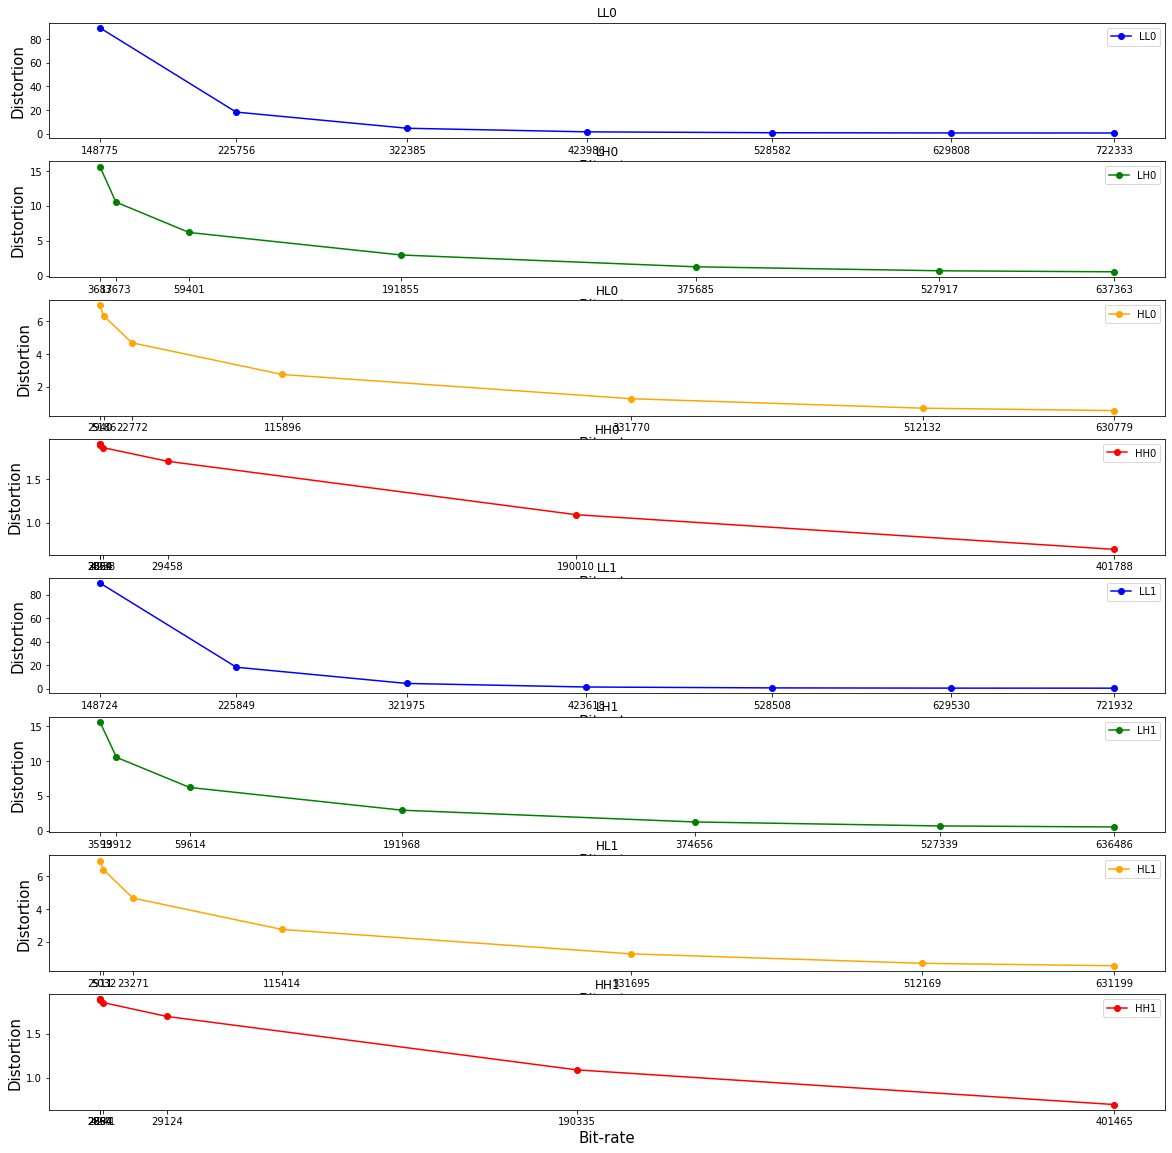

In [74]:
colores={'LL0':"b", "LH0":"g", "HH0":"r", "HL0":"orange",'LL1':"b", "LH1":"g", "HH1":"r", "HL1":"orange"}
fig=plt.figure(figsize=(20,20))
spec = fig.add_gridspec(ncols=1, nrows=3)
n = 811
for tipo in totales:
    plt.subplot(n)
    plot = plt.plot([i[0] for i in totales[tipo]],[i[1] for i in totales[tipo]],'-bo', color=colores[tipo],label =tipo, linestyle='-')
    plt.xticks([i[0] for i in totales[tipo]])
    plt.ylabel("Distortion", fontsize = 15, color = 'black')
    plt.xlabel("Bit-rate", fontsize = 15, color = 'black')
    plt.title(tipo)
    plt.legend(loc="upper right")
    n+=1

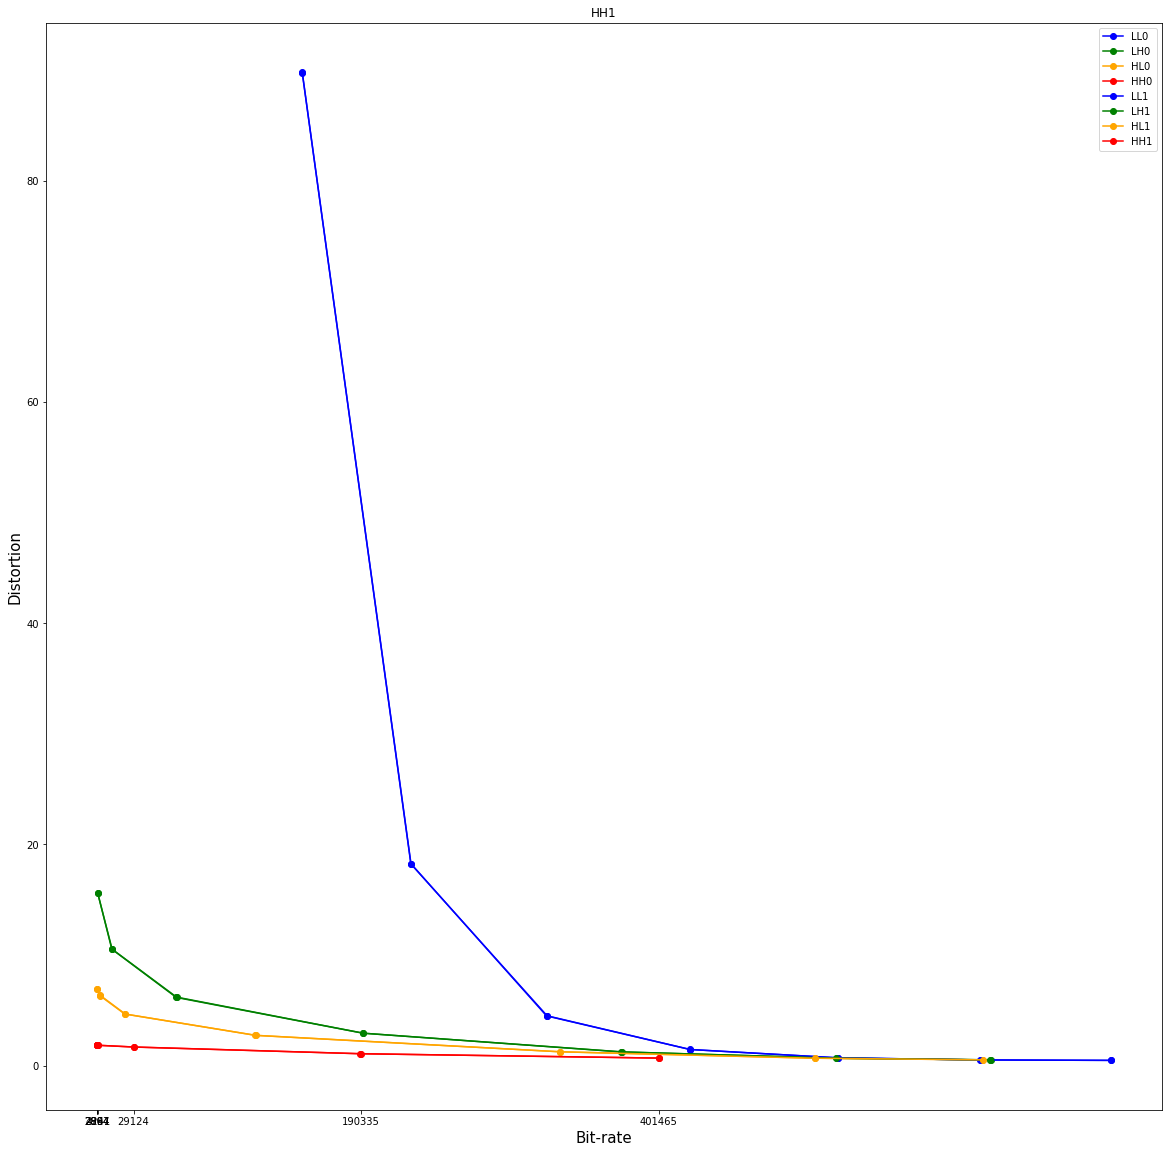

In [75]:
colores={'LL0':"b", "LH0":"g", "HH0":"r", "HL0":"orange",'LL1':"b", "LH1":"g", "HH1":"r", "HL1":"orange"}
fig=plt.figure(figsize=(20,20))
spec = fig.add_gridspec(ncols=1, nrows=3)
n = 811
for tipo in totales:
    plot = plt.plot([i[0] for i in totales[tipo]],[i[1] for i in totales[tipo]],'-bo', color=colores[tipo],label =tipo, linestyle='-')
    plt.xticks([i[0] for i in totales[tipo]])
    plt.ylabel("Distortion", fontsize = 15, color = 'black')
    plt.xlabel("Bit-rate", fontsize = 15, color = 'black')
    plt.title(tipo)
    plt.legend(loc="upper right")
    n+=1

In [76]:
slopes = [None]*C
for c in range(C):
    # Slopes of each pair of points
    slopes[c] = [] 
    for i in range(len(curve[c])-1):
        distortion_decrease = curve[c][i][1] - curve[c][i+1][1]
        rate_increase = curve[c][i+1][0] - curve[c][i][0]
        if(rate_increase==0): rate_increase=0.1
        slope = distortion_decrease/rate_increase
        slopes[c].append((slope, rate_increase, c))
    print(slopes[c])

[(4.270811784399488e-07, -92525.0, 0), (1.866778685031582e-06, -101226.0, 0), (7.19568406543092e-06, -104596.0, 0), (3.0002261984414253e-05, -101601.0, 0), (0.00014204051527850185, -96629.0, 0), (0.000928116018164689, -76981.0, 0)]
[(1.3466069485076804e-06, -109446.0, 1), (3.755580494860891e-06, -152232.0, 1), (9.188101871782864e-06, -183830.0, 1), (2.4412328089967527e-05, -132454.0, 1), (9.538575841205021e-05, -45728.0, 1), (0.0005091138417352003, -9986.0, 1)]
[(1.243803159412889e-06, -118647.0, 2), (3.211333926170778e-06, -180362.0, 2), (6.871610281386895e-06, -215874.0, 2), (2.0815300013754806e-05, -93124.0, 2), (9.401747700672078e-05, -17586.0, 2), (0.00028279244964620723, -2246.0, 2)]
[(1.8662071859873445e-06, -211778.0, 3), (3.7844419544049805e-06, -160552.0, 3), (6.1285637561335215e-06, -25220.0, 3), (2.6234571640790205e-05, -1209.0, 3), (4.673505070233604e-05, -165.0, 3), (0.0, 0.1, 3)]
[(4.398439734677985e-07, -92402.0, 4), (1.8821150178079332e-06, -101022.0, 4), (7.1916755880

In [77]:
total_slopes = []
for c in range(C):
    total_slopes += slopes[c]
print(total_slopes)

[(4.270811784399488e-07, -92525.0, 0), (1.866778685031582e-06, -101226.0, 0), (7.19568406543092e-06, -104596.0, 0), (3.0002261984414253e-05, -101601.0, 0), (0.00014204051527850185, -96629.0, 0), (0.000928116018164689, -76981.0, 0), (1.3466069485076804e-06, -109446.0, 1), (3.755580494860891e-06, -152232.0, 1), (9.188101871782864e-06, -183830.0, 1), (2.4412328089967527e-05, -132454.0, 1), (9.538575841205021e-05, -45728.0, 1), (0.0005091138417352003, -9986.0, 1), (1.243803159412889e-06, -118647.0, 2), (3.211333926170778e-06, -180362.0, 2), (6.871610281386895e-06, -215874.0, 2), (2.0815300013754806e-05, -93124.0, 2), (9.401747700672078e-05, -17586.0, 2), (0.00028279244964620723, -2246.0, 2), (1.8662071859873445e-06, -211778.0, 3), (3.7844419544049805e-06, -160552.0, 3), (6.1285637561335215e-06, -25220.0, 3), (2.6234571640790205e-05, -1209.0, 3), (4.673505070233604e-05, -165.0, 3), (0.0, 0.1, 3), (4.398439734677985e-07, -92402.0, 4), (1.8821150178079332e-06, -101022.0, 4), (7.19167558804991

In [78]:
sorted_slopes = sorted(total_slopes, key=lambda tup: tup[0])[::-1]
print(sorted_slopes)

[(0.000928116018164689, -76981.0, 0), (0.0009276359867238149, -77125.0, 4), (0.0005091138417352003, -9986.0, 1), (0.000494715399846775, -10313.0, 5), (0.00028279244964620723, -2246.0, 2), (0.0002570614756555642, -2121.0, 6), (0.00014306984231452874, -96126.0, 4), (0.00014204051527850185, -96629.0, 0), (9.538575841205021e-05, -45728.0, 1), (9.536247244819557e-05, -18239.0, 6), (9.466952376216137e-05, -45702.0, 5), (9.401747700672078e-05, -17586.0, 2), (4.673505070233604e-05, -165.0, 3), (3.9507133719717035e-05, -133.0, 7), (3.0002261984414253e-05, -101601.0, 0), (2.984010862072178e-05, -101643.0, 4), (2.6234571640790205e-05, -1209.0, 3), (2.5239830657642757e-05, -1244.0, 7), (2.4634919158710968e-05, -132354.0, 5), (2.4412328089967527e-05, -132454.0, 1), (2.0815300013754806e-05, -93124.0, 2), (2.078228497464162e-05, -92143.0, 6), (9.263315136028346e-06, -182688.0, 5), (9.188101871782864e-06, -183830.0, 1), (7.19568406543092e-06, -104596.0, 0), (7.191675588049915e-06, -104890.0, 4), (6.89

## Step 8. Bit Rate

In [81]:
R = 6.4 # Bit budget
spent_br = 0 # Spent bit rate
i = 0
optimal_progression = []
while True:
    try:
        spent_br += sorted_slopes[i][1]
        if spent_br < R:
            optimal_progression.append(sorted_slopes[i])
        else:
            break
        i += 1
    except:
        break
print("Optimal progression of RD points =", optimal_progression)
br = sum([i[1] for i in optimal_progression])
print("Achieved rate =", br)
for c in range(C): # 4 = four curves
    br = sum([i[1] for i in optimal_progression if i[2] == c])
    print("Rate for curve {} = {}".format(c,br))

Optimal progression of RD points = [(0.000928116018164689, -76981.0, 0), (0.0009276359867238149, -77125.0, 4), (0.0005091138417352003, -9986.0, 1), (0.000494715399846775, -10313.0, 5), (0.00028279244964620723, -2246.0, 2), (0.0002570614756555642, -2121.0, 6), (0.00014306984231452874, -96126.0, 4), (0.00014204051527850185, -96629.0, 0), (9.538575841205021e-05, -45728.0, 1), (9.536247244819557e-05, -18239.0, 6), (9.466952376216137e-05, -45702.0, 5), (9.401747700672078e-05, -17586.0, 2), (4.673505070233604e-05, -165.0, 3), (3.9507133719717035e-05, -133.0, 7), (3.0002261984414253e-05, -101601.0, 0), (2.984010862072178e-05, -101643.0, 4), (2.6234571640790205e-05, -1209.0, 3), (2.5239830657642757e-05, -1244.0, 7), (2.4634919158710968e-05, -132354.0, 5), (2.4412328089967527e-05, -132454.0, 1), (2.0815300013754806e-05, -93124.0, 2), (2.078228497464162e-05, -92143.0, 6), (9.263315136028346e-06, -182688.0, 5), (9.188101871782864e-06, -183830.0, 1), (7.19568406543092e-06, -104596.0, 0), (7.191675